In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traffic/model2_uncongested_traffic_dataset.csv/model2_uncongested_traffic_dataset.csv
/kaggle/input/traffic/model2_congested_traffic_dataset.csv/model2_congested_traffic_dataset.csv


In [2]:
import os

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import keras_tuner as kt

import gc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# *Importing and Transforming Dataset*

In [3]:
def label_counter(inpt, data_name):
    c = 0
    u = 0
    for i in inpt:
        if i == 1:
            c = c+1
        elif i == 0:
            u = u + 1
    print(f'{data_name} --> Congested: {c}, Uncongested: {u}')

In [4]:
def import_dataset(split_seed):
    
    #First dataset
    congested = pl.read_csv('/kaggle/input/traffic/model2_congested_traffic_dataset.csv/model2_congested_traffic_dataset.csv')
    
    #Second dtaset
    uncongested = pl.read_csv('/kaggle/input/traffic/model2_uncongested_traffic_dataset.csv/model2_uncongested_traffic_dataset.csv')
    
    #Combining first and second dataset
    df = pl.concat([congested, uncongested], how="vertical")
    
    y = df[:, 0] # Getting labels as series
    y = y.to_numpy()
    
    df = df[:, 1:]/255.0 # Normalizing pixels value to range of 0 to 1
    df = df.to_numpy().reshape(-1, 222, 296, 1) #reshaping to 296 by 222

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1, random_state=split_seed) #42

    # Split train data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=split_seed)
    
    label_counter(y_train, 'y_train')
    label_counter(y_test, 'y_test')
    label_counter(y_val, 'y_val')
    
    return X_train, y_train, X_test, y_test, X_val, y_val

In [5]:
X_train, y_train, X_test, y_test, X_val, y_val = import_dataset(25)

y_train --> Congested: 1878, Uncongested: 1862
y_test --> Congested: 255, Uncongested: 235
y_val --> Congested: 328, Uncongested: 333


# ***Exploratory Data Analysis***

In [6]:
import plotly.graph_objects as go
# Define class labels
class_labels = {0: 'Congested images', 1: 'Uncongested images'}

In [7]:
# Map class labels for visualization
train_classes = np.array([class_labels[label] for label in y_train])
test_classes = np.array([class_labels[label] for label in y_test])
val_classes = np.array([class_labels[label] for label in y_val])

In [8]:
# Calculate class frequencies
train_class_counts = np.unique(train_classes, return_counts=True)
test_class_counts = np.unique(test_classes, return_counts=True)
val_class_counts = np.unique(val_classes, return_counts=True)

In [9]:
# Create bar chart data
data = [
    go.Bar(x=train_class_counts[0], y=train_class_counts[1], name='Train'),
    go.Bar(x=test_class_counts[0], y=test_class_counts[1], name='Test'),
    go.Bar(x=val_class_counts[0], y=val_class_counts[1], name='Validation')
]

In [10]:
# Set layout
layout = go.Layout(
    title='Occurrences of Binary Classes',
    xaxis=dict(title='Class'),
    yaxis=dict(title='Count'),
    barmode='group'
)

# Create figure
fig = go.Figure(data=data, layout=layout)

# Show the bar chart
fig.show()

In [11]:
# Define class labels
class_labels = {
    0: 'Congested',
    1: 'Uncongested'
}

# Calculate total class counts
class_counts = {
    class_labels[0]: np.sum([np.sum(y_train == 0), np.sum(y_test == 0), np.sum(y_val == 0)]),
    class_labels[1]: np.sum([np.sum(y_train == 1), np.sum(y_test == 1), np.sum(y_val == 1)])
}

# Create bar chart data
data = [
    go.Bar(x=list(class_counts.keys()), y=list(class_counts.values()))
]

# Set layout
layout = go.Layout(
    title='Total Occurrences of Binary Classes',
    xaxis=dict(title='Class'),
    yaxis=dict(title='Count')
)

# Create figure
fig = go.Figure(data=data, layout=layout)

# Show the bar chart
fig.show()

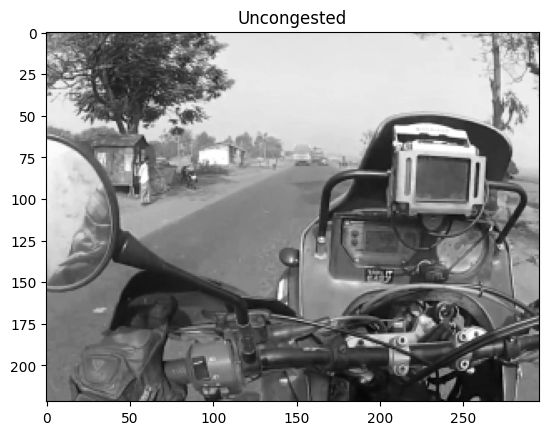

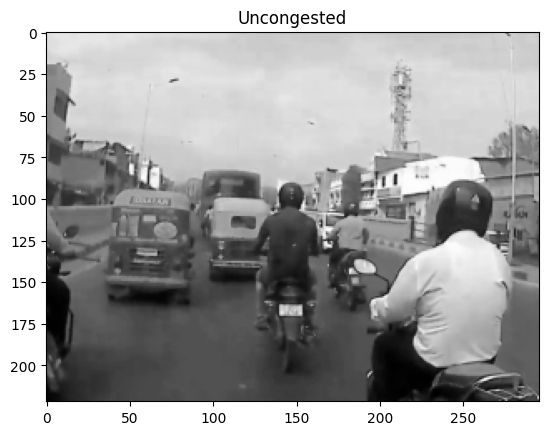

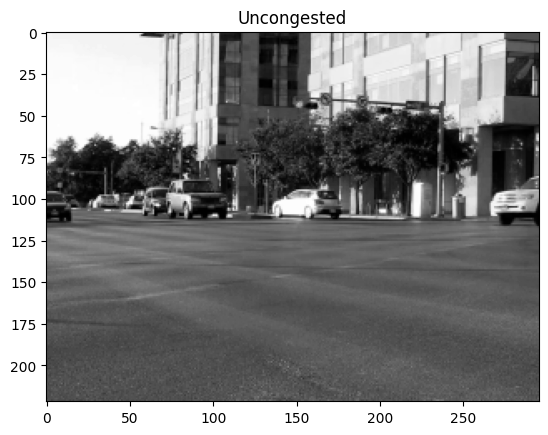

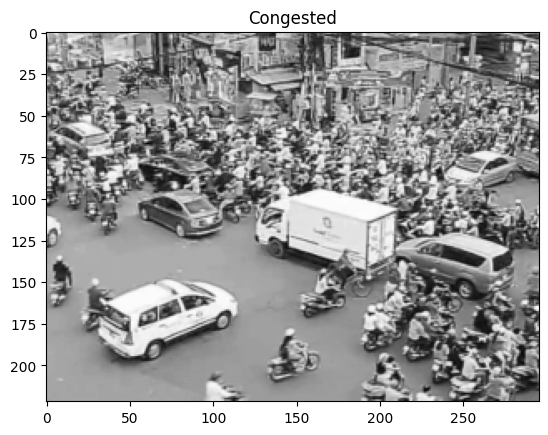

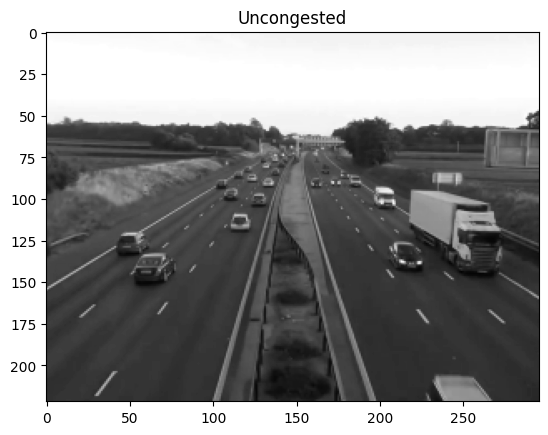

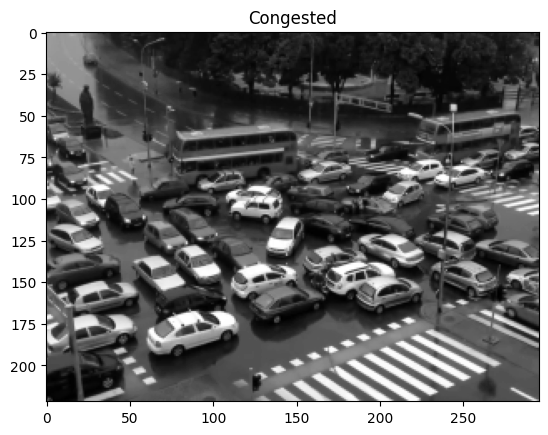

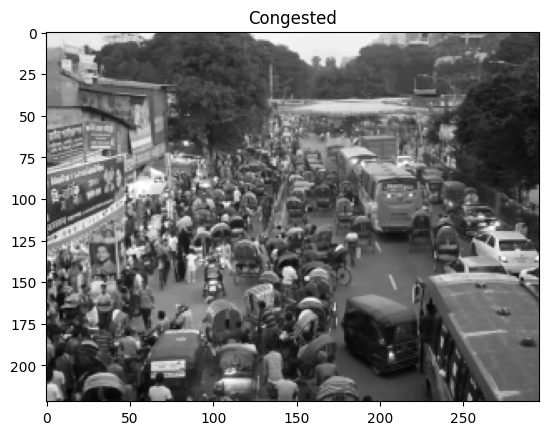

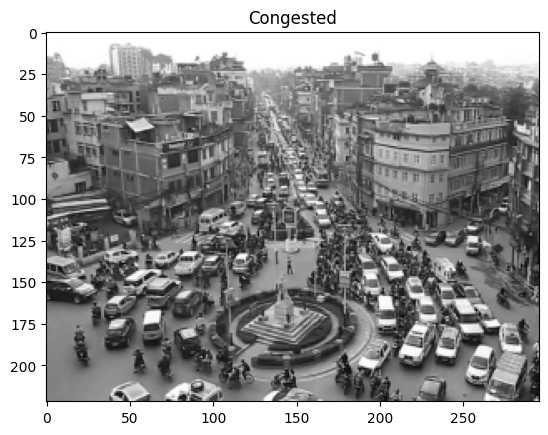

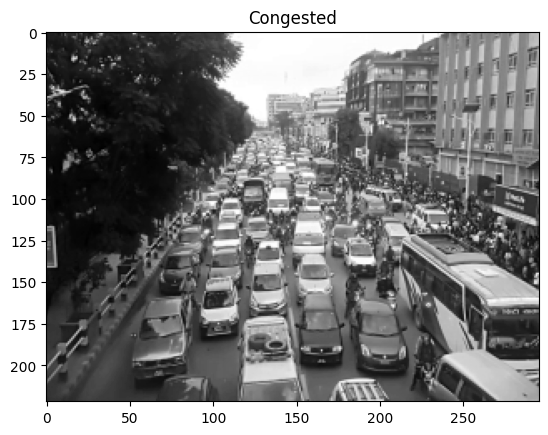

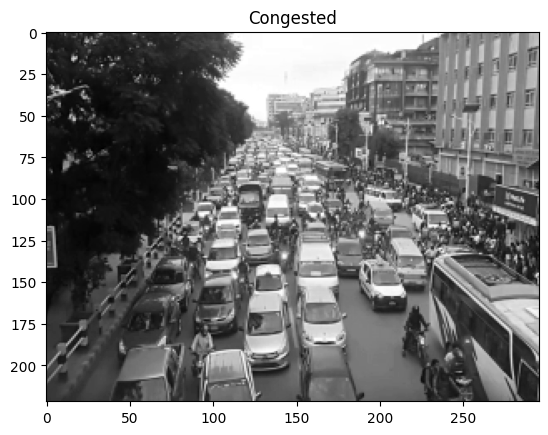

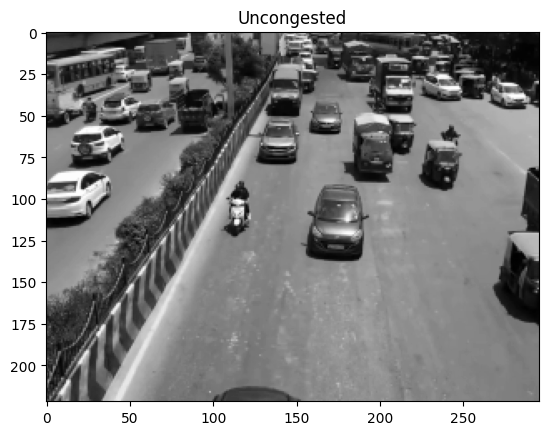

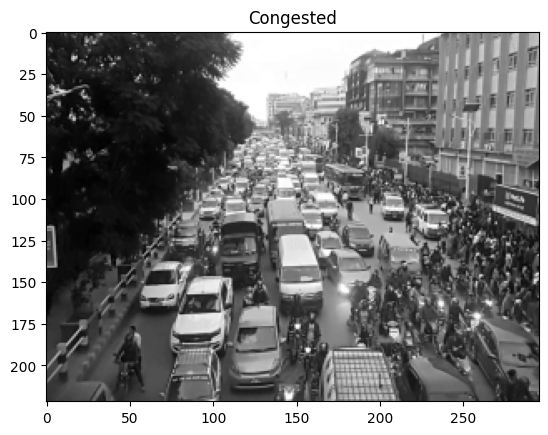

In [12]:
def image_visualizer(X, y, row_number):
    X = X[row_number]
    y = y[row_number]

    plt.imshow(X, cmap='gray')
    lbl = None
    if y == 0:
        lbl = 'Uncongested'
    elif y == 1:
        lbl = 'Congested'
    plt.title(lbl)
    plt.show()

image_visualizer(X_train, y_train, 5)
image_visualizer(X_train, y_train, 225)
image_visualizer(X_train, y_train, 512)
image_visualizer(X_train, y_train, 995)
image_visualizer(X_train, y_train, 15)
image_visualizer(X_train, y_train, 1225)
image_visualizer(X_train, y_train, 1512)
image_visualizer(X_train, y_train, 1995)
image_visualizer(X_train, y_train, 25)
image_visualizer(X_train, y_train, 2225)
image_visualizer(X_train, y_train, 2512)
image_visualizer(X_train, y_train, 2995)

# **Model**

In [13]:
def model_builder(hp):
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(hp.Int('filter_1', min_value=5, max_value=100, step=10), hp.Choice('filter_size_1', values=[3, 4, 5]), activation='relu', input_shape=(222, 296, 1)))
    model.add(keras.layers.MaxPooling2D(hp.Choice('kernel_size_1', values=[1, 2, 3, 4])))
    
    model.add(keras.layers.Conv2D(hp.Int('filter_2', min_value=5, max_value=70, step=5), hp.Choice('filter_size_2', values=[2, 3]), activation='relu'))
    model.add(keras.layers.MaxPooling2D(hp.Choice('kernel_size_2', values=[1, 2, 3, 4])))
    
    model.add(keras.layers.Conv2D(hp.Int('filter_3', min_value=5, max_value=70, step=5), hp.Choice('filter_size_3', values=[2, 3]), activation='relu'))
    model.add(keras.layers.MaxPooling2D(hp.Choice('kernel_size_3', values=[1, 2, 3, 4])))
    
    model.add(keras.layers.Conv2D(hp.Int('filter_4', min_value=5, max_value=70, step=5), hp.Choice('filter_size_4', values=[2, 3]), activation='relu'))
    model.add(keras.layers.MaxPooling2D(hp.Choice('kernel_size_4', values=[1, 2, 3])))
              
    model.add(keras.layers.Conv2D(hp.Int('filter_5', min_value=5, max_value=70, step=5), hp.Choice('filter_size_5', values=[1, 2, 3]), activation='relu'))
    model.add(keras.layers.MaxPooling2D(hp.Choice('kernel_size_5', values=[1, 2, 3])))
        
    model.add(keras.layers.Conv2D(hp.Int('filter_6', min_value=5, max_value=80, step=5), hp.Choice('filter_size_6', values=[1, 2, 3]), activation='relu'))
    model.add(keras.layers.MaxPooling2D(hp.Choice('kernel_size_6', values=[1, 2, 3])))
              
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=hp.Int('units_1', min_value=5, max_value=100, step=10), activation='relu'))
    
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(hp_dropout_rate))
    
    model.add(keras.layers.Dense(hp.Int('units_2', min_value=5, max_value=55, step=5), activation='relu'))
    
    model.add(keras.layers.Dense(2, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0003, 0.0001])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model


In [15]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/kaggle/working/',
                     project_name='congested_vs_uncongested_traffic_detector')
              
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=15, validation_data=(X_val, y_val), callbacks=[stop_early])

Trial 23 Complete [00h 01m 14s]
val_accuracy: 0.8078668713569641

Best val_accuracy So Far: 0.9788199663162231
Total elapsed time: 00h 13m 01s


In [16]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [17]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 220, 294, 95)      950       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 147, 95)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 146, 20)      7620      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 109, 146, 20)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 107, 144, 50)      9050      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 35, 48, 50)      

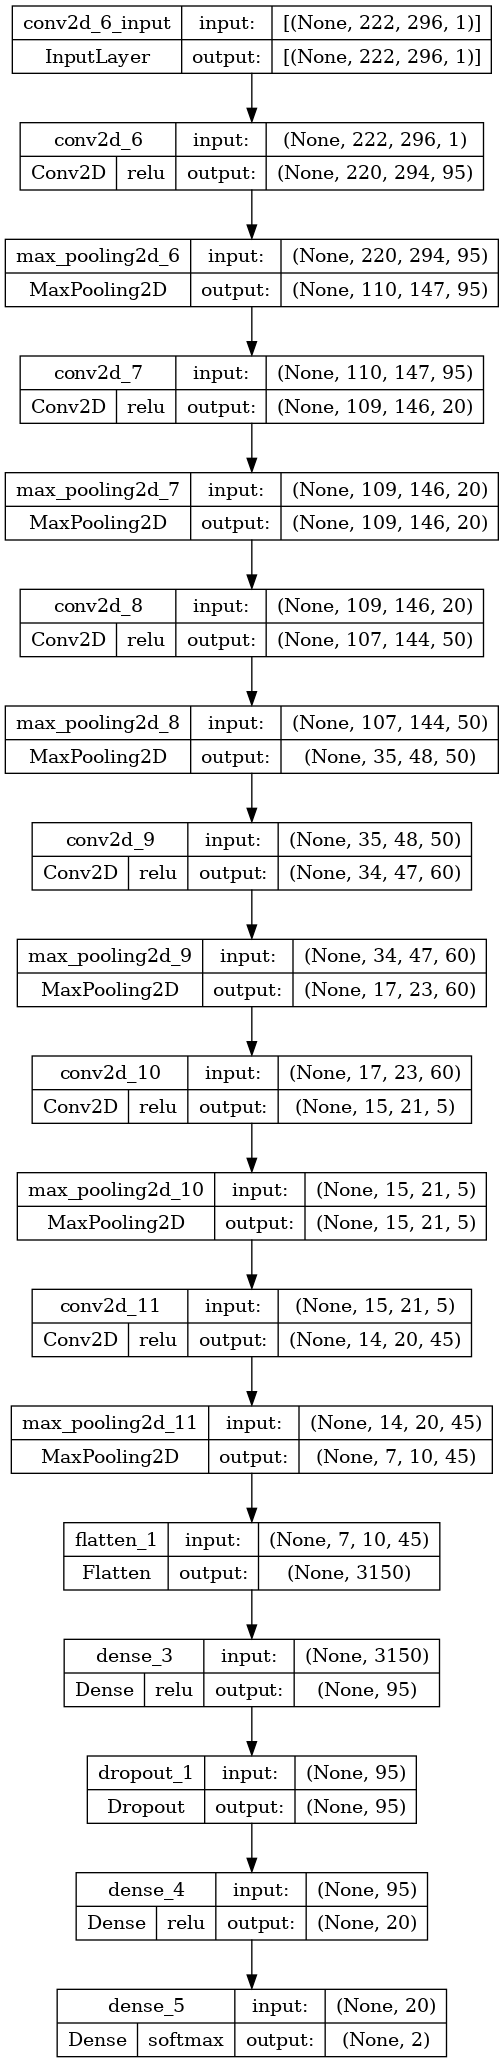

In [18]:
tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

In [19]:
# Data augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [20]:
history = model.fit(datagen.flow(X_train, y_train),
                    validation_data=(X_val, y_val),
                    epochs=60)

Epoch 1/60
117/117 [==============================] - 20s 146ms/step - loss: 0.6559 - accuracy: 0.5930 - val_loss: 0.4130 - val_accuracy: 0.8139
Epoch 2/60
117/117 [==============================] - 17s 140ms/step - loss: 0.3508 - accuracy: 0.8580 - val_loss: 0.4635 - val_accuracy: 0.7685
Epoch 3/60
117/117 [==============================] - 16s 140ms/step - loss: 0.3130 - accuracy: 0.8703 - val_loss: 0.4322 - val_accuracy: 0.8018
Epoch 4/60
117/117 [==============================] - 17s 141ms/step - loss: 0.2731 - accuracy: 0.9000 - val_loss: 0.1929 - val_accuracy: 0.9380
Epoch 5/60
117/117 [==============================] - 17s 140ms/step - loss: 0.2689 - accuracy: 0.8987 - val_loss: 0.2229 - val_accuracy: 0.9213
Epoch 6/60
117/117 [==============================] - 16s 139ms/step - loss: 0.2452 - accuracy: 0.9102 - val_loss: 0.1976 - val_accuracy: 0.9213
Epoch 7/60
117/117 [==============================] - 17s 141ms/step - loss: 0.2254 - accuracy: 0.9128 - val_loss: 0.2007 - val_ac

In [21]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 58


In [22]:
index = 1
print(y_test[index])
model.predict(X_test[index].reshape(-1, 222, 296, 1))

1
1/1 [==============================] - 0s 367ms/step


array([[0.00125917, 0.99874085]], dtype=float32)

In [23]:
model.save('/kaggle/working/model')

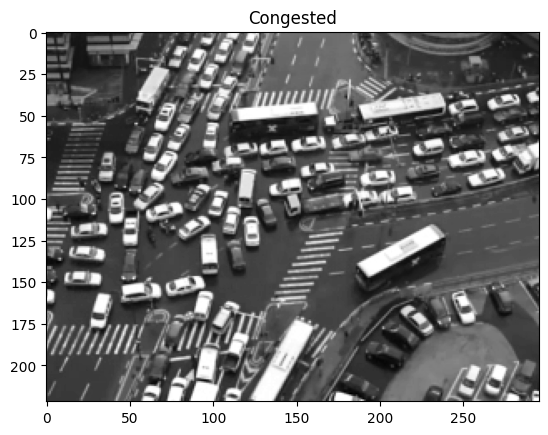

In [25]:
image_visualizer(X_val, y_val, 7)

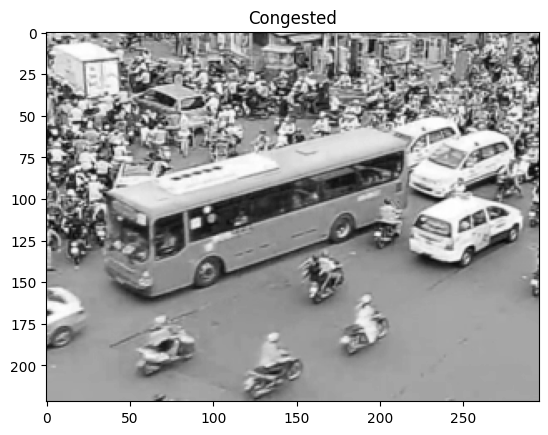

In [26]:
image_visualizer(X_val, y_val, 17)

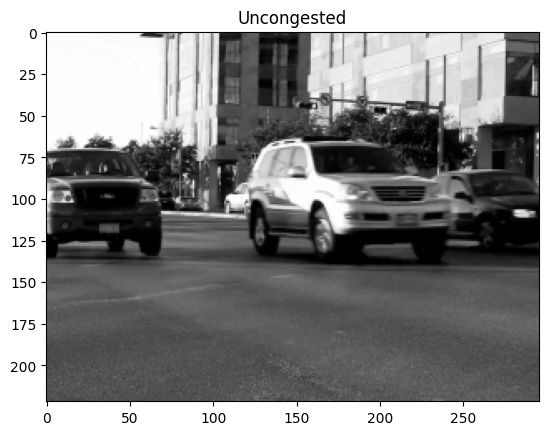

In [27]:
image_visualizer(X_val, y_val, 234)

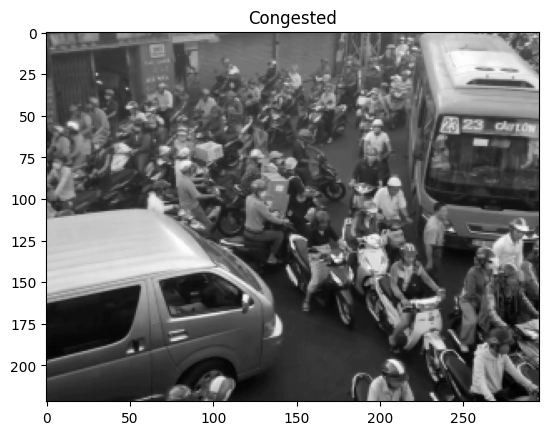

In [28]:
image_visualizer(X_val, y_val, 171)

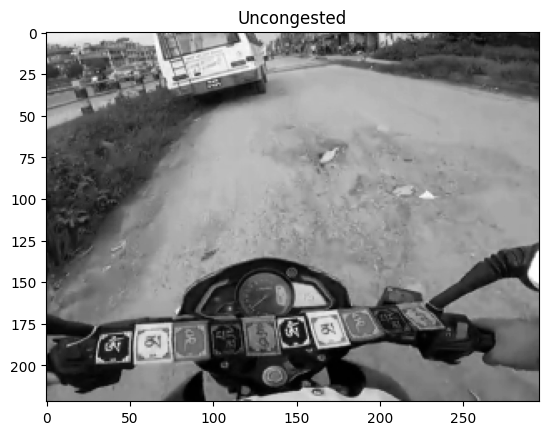

In [29]:
image_visualizer(X_val, y_val, 117)